In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.utils import shuffle
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.location = np.array([["".join([y.strip() for y in str(x).split()])]for x in df.location]).reshape(1,-1)[0]
df.keyword = df.keyword.astype("str")

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer() 
stopwords = stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


In [173]:
from wordcloud import WordCloud, STOPWORDS
#Wordcloud REAL
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate("".join([x.lower() for x in df.text[df.target==1]]))

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

ModuleNotFoundError: No module named 'wordcloud'

In [174]:
#WORDCLOUD FAKE
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate("".join([x.lower() for x in df.text[df.target==0]]))

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

NameError: name 'WordCloud' is not defined

In [5]:

def pos_lemmatize(sentence):
    values = [x.lower() for x in word_tokenize(sentence)]
    pos = nltk.pos_tag(values)
    dict_pos = {"J": wordnet.ADJ,
                "NN": wordnet.NOUN,
                "VBD": wordnet.VERB,
                "VBZ": wordnet.VERB,
                "VBG": wordnet.VERB,
                "VBN": wordnet.VERB,
                "RB": wordnet.ADV}
    values = [lemmatizer.lemmatize(values[x],pos=dict_pos.get(pos[x][1], wordnet.NOUN)) for x in range(len(values))] 
    values = [value for value in values if value not in stopwords] # and len(value) > 1
    return " ".join(values)
df["n-text"] = df.text.apply(pos_lemmatize) #get lemmatized words for each word in sentence - lemmatized: walked --> walk


In [6]:
df["n-text"]

0            deed reason # earthquake may allah forgive u
1                 forest fire near la ronge sask . canada
2       resident ask 'shelter place ' notify officer ....
3       13,000 people receive # wildfire evacuation or...
4       get send photo ruby # alaska smoke # wildfire ...
                              ...                        
7608    two giant crane hold bridge collapse nearby ho...
7609    @ aria_ahrary @ thetawniest control wild fire ...
7610    m1.94 [ 01:04 utc ] ? 5km volcano hawaii . htt...
7611    police investigate e-bike collided car little ...
7612    latest : home raze northern california wildfir...
Name: n-text, Length: 7613, dtype: object

In [7]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size = 1000
df["encoded"] = [one_hot(sentence, vocab_size) for sentence in df["n-text"]]

In [8]:
df.encoded

0                      [37, 848, 383, 209, 291, 971, 921]
1                      [268, 513, 452, 254, 82, 348, 193]
2       [982, 697, 704, 84, 700, 828, 292, 918, 668, 8...
3                [483, 433, 605, 198, 488, 918, 689, 132]
4            [126, 994, 195, 85, 522, 414, 488, 932, 206]
                              ...                        
7608    [823, 895, 713, 567, 761, 753, 645, 734, 850, ...
7609    [276, 819, 521, 383, 394, 513, 132, 120, 515, ...
7610    [415, 819, 562, 247, 293, 307, 395, 199, 850, ...
7611    [112, 376, 232, 317, 922, 701, 308, 689, 232, ...
7612    [549, 734, 571, 515, 132, 488, 108, 865, 850, ...
Name: encoded, Length: 7613, dtype: object

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 20
X = pad_sequences(list(df.encoded), maxlen=max_length, padding='pre')

In [14]:
y = df.target

In [15]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) #default shuffle = True but random state = 42 means always same random shuffle



In [16]:
from tensorflow.keras.layers import Embedding,Dense,LSTM,Dropout,concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
#from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(1000,embedding_vector_features,input_length=20)) ## embedding layer used 40 features to make feature representation of the sentences
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3)) ## drop out layer to make the model more regularized
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary()) ## model architechture done


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            40000     
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 96,501
Trainable params: 96,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
"""def build_model(lstm_shape):
    dropout = 0.5
    
    # First part of the network for keyword and location
    dense_input = tf.keras.layers.Input(shape=(20))
    dense1 = tf.keras.layers.Dense(15)(dense_input)
    
    # Second part of the network for the text analysis
    lstm_input = tf.keras.layers.Input(shape=(lstm_shape))
    lstm1 = tf.keras.layers.LSTM(units=350, return_sequences=True)(lstm_input)
    lstm2 = tf.keras.layers.Dropout(dropout)(lstm1)
    lstm3 = tf.keras.layers.LSTM(units=50, return_sequences=True)(lstm2)
    lstm4 = tf.keras.layers.Flatten()(lstm3)
    lstm5 = tf.keras.layers.Dense(50)(lstm4)
    
    # Concatenate part for concatenating the two parts above
    concat1 = tf.keras.layers.Concatenate()([dense1, lstm5])
    concat2 = tf.keras.layers.Dropout(dropout)(concat1)
    concat3 = tf.keras.layers.Dense(50)(concat2)
    
    # Output of model
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(concat3)
    
    # Compile the model
    model = tf.keras.Model(inputs=[dense_input, lstm_input], outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
    
    return model
build_model()"""

In [17]:
history = model.fit(x_train, y_train, validation_split=.2, epochs=2, batch_size=5, verbose=1)

Epoch 1/2
975/975 [==============================] - 13s 11ms/step - loss: 0.6261 - accuracy: 0.6444 - val_loss: 0.5342 - val_accuracy: 0.7365
Epoch 2/2
975/975 [==============================] - 9s 10ms/step - loss: 0.4680 - accuracy: 0.7902 - val_loss: 0.5580 - val_accuracy: 0.7430


In [116]:
#history = model.fit([Xtext, Xother], y, validation_split=.2, epochs=5, batch_size=5, verbose=1)
#history = model.fit([Xtext_train, Xother_train], y_train, validation_split=.2, epochs=5, batch_size=5, verbose=1)
#Does best when you use to both but I guess because the test and train data is in the first one

In [18]:
loss, accuracy = model.evaluate(x_test,y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 74.917924


In [19]:
model.save("final-TextOnly")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2289: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1376: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: final-TextOnly/assets


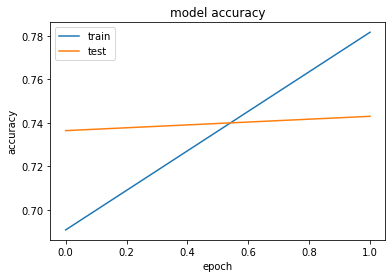

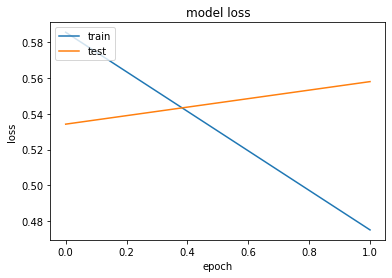

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
def prepareData(df):
    df["n-text"] = df.text.apply(pos_lemmatize)
    vocab_size = 1000
    df["encoded"] = [one_hot(sentence, vocab_size) for sentence in df["n-text"]]
    max_length = 20
    text = pad_sequences(list(df.encoded), maxlen=max_length, padding='pre')
    return text
tf = pd.read_csv("test.csv")
text = prepareData(tf)

In [25]:
submission = pd.DataFrame({"id":tf.id,"target":[int(round(x,0)) for x in model.predict(text).reshape(1,-1)[0]]})
submission.to_csv("submission-simple.csv", index=False)

In [298]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


In [27]:
np.zeros((10, 20, 50)).shape

(10, 20, 50)